# Problem Set 11: Scheduling and MILP (160 points)
## Due Friday, December 8th, 11:59 p.m.


### Scheduling (60 points)
As [the Doctor](https://en.wikipedia.org/wiki/Doctor_Who) wisely pointed out, dealing with time isn't always easy:
<img src="timey-wimey.png" width="400" height="300"/>

Next, in this problem set, you'll implement an offline scheduler to help an agent deal with time. You'll also do some temporal modeling and think about a completely different way to schedule.

1. [Modeling](#Modeling-Example)
    1. [Modeling Example](#Modeling-Example)
    2. [Temporal Word Problem (10 points)](#temporal-word-problem)
2. [Dispatchable Form](#Dispatchable-Form)
    1. [Distance-graph Transformation (5 points)](#distance-graph-transformation)
    2. [Computing Dispatchable Form (10 points)](#computing-dispatchable-form)
3. [Scheduling](#offline-scheduler)
    1. [Offline Scheduler (25 points)](#offline-scheduler)
4. [Scheduling as Linear Programming (10 points)](#scheduling-as-lp)

### MILP (100 points)

1. [LP Formulation (40 points)](#part1)
2. [MILP Formulation (20 points)](#part2)
    1. [Knapsack Problem (10 points)](#part2a)
    2. [Map Coloring (10 points)](#part2b)
3. [MILPs and Numberjack (40 points)](#part3)
    1. [Knapsack Problem (10 points)](#part3a)
    2. [Map Coloring (30 points)](#part3b) 

## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

Got help from Shashank to properly create STNs (with the (0,inf) bracket between events) for the get to class problem. Got help from Anoop on each LP formulation for the lunar problem and help figuring out how to write the constraints for the adjacent states in the map coloring problem. Also learned how to use latex formula writing from a student (don't know her name) in OH.

Make sure you load the dependencies below by highlighting the cell below and pressing Shift + Enter.

In [3]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import numpy as np
from render import *
from utils import *
from dispatcher import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

## Part 1 - Simple Temporal Networks (60 points)

### Modeling Example <a href="Modeling-Example"/>

To get started, first we'll introduce how we represent simple temporal networks (STNs) and distance graphs. We'll be using the [networkx](https://networkx.github.io) Python package to represent directed graphics. We recommend you skim the documentation if you're not familiar with this package.

Here is a quick example of how we can create an STN, with several simple temporal constraints (STCs):

In [4]:
stn = nx.DiGraph()
stn.add_edge('A', 'B', stc=[0, 10])
stn.add_edge('B', 'D', stc=[1, 1])
stn.add_edge('A', 'C', stc=[0, 10])
stn.add_edge('C', 'D', stc=[2, 2])

The above example adds simple temporal constraints. We don't need to explicitly declare the set of nodes. Note that in `networkx`, we can add any arbitrary keys after the two nodes specifying an event - here we use `stc`, but later in your implementation you could also specify any other keys if you want (they'll get lumped together in a dictionary).

To access the STCs, you can do so with `stn[from_node][to_node][key]`. For example:

In [5]:
stn['A']['B']['stc']

[0, 10]

If you want to specify other values, such as $\infty$, you can use `numpy` with `np.inf` or `-np.inf`.

We've also provided you with some code to visualize STNs and distance graphs, namely the `display_stn` and `display_weighted_graph` functions. These can be useful in your debugging:

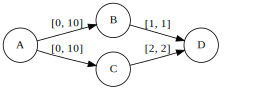

In [6]:
# Shows the STN
display_stn(stn)

The `networkx` package also has some other useful methods, for example for retrieving all the nodes, iterating over all the edges, etc.

Note that we'll be using the STN example above for many sections of this problem set.

### Temporal Word Problem (10 pts) <a id="temporal-word-problem"/>

In this section, you'll model a word problem as an STN.

Consider the following scenario:

> Oh no, you're late for PADM class! It's currently 8:30am (the start of your day), but you still have a lot of stuff to do. You need to arrive to campus in no more than an hour by 9:30am, otherwise you'll be late for another exciting lecture. First, you need to take a shower, which will take you between between 5 and 10 minutes. Once you're done, you'll do two things in parallel to multitask and save time: 1.) you'll eat your breakfast, which takes at least 15 minutes but not more than 20 minutes, 2.) you'll review your notes from last lecture. First you'll review scheduling algorithms and then afterwards you'll review planning algorithms (each takes 10 to 15 minutes to review). After you're done studying and eating, you need to pack your bag (exactly 5 minutes). Finally, you'll ride your bike to lecture. There seems to be a lot of traffic though, so the timing is pretty variable - that could take between 15 minutes to 20 minutes.

<br/>
<div class="alert alert-info">
Model this scenario as an STN below.
</div>

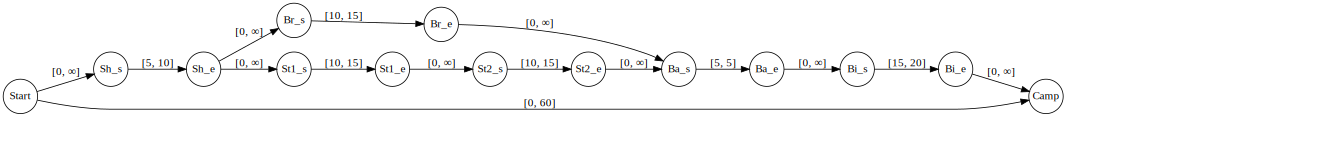

In [7]:
def temporal_word_problem():
    stn_late = nx.DiGraph()
    
    # YOUR CODE HERE
    #stn_late.add_edge('H', 'C', stc=[0, 60])
    #stn_late.add_edge('Sh', 'Br', stc=[5, 10])
    #stn_late.add_edge('Sh', 'STN', stc=[5, 10])
    #stn_late.add_edge('STN', 'Plan', stc=[10, 15])
    #stn_late.add_edge('Br', 'Bag', stc=[15, 20])
    #stn_late.add_edge('STN', 'Bag', stc=[10, 15])
    #stn_late.add_edge('Plan', 'Bag', stc=[10, 15])
    #stn_late.add_edge('Bag', 'Bike', stc=[5, 5])
    #stn_late.add_edge('Bike', 'Camp', stc=[15, 20])
    #stn_late.add_edge('Sh', 'Camp', stc=[0, 60])
    
    stn_late.add_edge('Start', 'Sh_s', stc=[0, np.inf])
    stn_late.add_edge('Sh_s', 'Sh_e', stc=[5, 10])
    stn_late.add_edge('Sh_e', 'Br_s', stc=[0, np.inf])
    stn_late.add_edge('Br_s', 'Br_e', stc=[10, 15])
    stn_late.add_edge('Sh_e', 'St1_s', stc=[0, np.inf])
    stn_late.add_edge('St1_s', 'St1_e', stc=[10, 15])
    stn_late.add_edge('St1_e', 'St2_s', stc=[0, np.inf])
    stn_late.add_edge('St2_s', 'St2_e', stc=[10, 15])
    stn_late.add_edge('Br_e', 'Ba_s', stc=[0, np.inf])
    stn_late.add_edge('St2_e', 'Ba_s', stc=[0, np.inf])
    stn_late.add_edge('Ba_s', 'Ba_e', stc=[5, 5])
    stn_late.add_edge('Ba_e', 'Bi_s', stc=[0, np.inf])
    stn_late.add_edge('Bi_s', 'Bi_e', stc=[15, 20])
    stn_late.add_edge('Bi_e', 'Camp', stc=[0, np.inf])
    stn_late.add_edge('Start', 'Camp', stc=[0, 60])
    
    
    return stn_late
    
# Shows the STN in graphviz
display_stn(temporal_word_problem())

### Dispatchable Form

In this section, we'll focus on converting an STN into a dispatchable form, so that we can find a consistent schedule using only local propagations to neighbors.

### Distance-graph Transformation (5 pts) <a id="distance-graph-transformation"/>

We'll start by converting the STN to a distance graph, which we'll also represent as a `networkx` graph. This time, however, instead of adding edges with an `stc` field, we'll use the more standard `weight` field (for example, we'd add an edge with `g.add_edge(u, v, weight=5.0)`).

<br/>
<div class="alert alert-info">
Implement the following method to convert an STN to a distance graph.
</div>

In [8]:
def convert_stn_to_distance_graph(stn):
    """Converts an STN to a distance graph.
    
    Input: stn - an STN (namely, an nx.DiGraph, with stc=... set for every edge)
    Output: dg - a distance graph representation of stn
    """
    # YOUR CODE HERE
    dg = nx.DiGraph()
    edges = list(stn.edges)
    for edge in edges:
        weights = stn[edge[0]][edge[1]]['stc']
        dg.add_edge(edge[0], edge[1], weight=weights[1])
        dg.add_edge(edge[1], edge[0], weight=-weights[0])
    
    return dg
    

Let's convert the STN example above to a distance graph, visualize it, and test it:

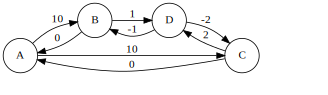

Test passed!!

In [9]:
def test_stn_to_dg_conversion():
    stn = create_example_stn_1()
    dg = convert_stn_to_distance_graph(stn)

    display_weighted_graph(dg)
    test_distance_graph(dg, stn)
    test_ok()

test_stn_to_dg_conversion()

### Computing a Dispatchable Form (10 pts) <a id="computing-dispatchable-form"/>

Now that we can operate on a distance graph, the next step is to compute a dispatchable form of the network. There are different dispatchable forms, here we'll implement the simplest. Recall that a dispatchable form exposes all of the implicit constraints in the network, making them explicit so that our local propagation algorithm will work properly.

In this section, we'll be converting the distance graph about to a dispatchable form by computing an all-pairs shortest path. Due to it's simplicity, we recommend the Floyd Warshall algorithm, which can handle negative edges and detect negative cycles, but faster algorithms exist for the all-pairs shortest path. Feel free to implement this however you see fit, but it may be useful to know that `networkx` has an array of [shortest path graph algorithms](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html).

<br/>
<div class="alert alert-info">
Implement the following method to compute an all-pairs-shortest-path (APSP) dispatchable form of the distance graph.
</div>

In [88]:
def compute_apsp_dispatchable_form(dg):
    """Converts a distance graph, g, to a dispatchable form.
    
    This method should compute the APSP of g, and then create
    and return a new graph over the same nodes in g but with the
    edges from the APSP in the graph. It should include every edge EXCEPT for
    self-loop edges from a node to itself.
    
    Input: dg - a distance graph represented as a `networkx` graph.
    Output: g_apsp - a distance graph representing the APSP dispatchable form of dg
    """
    # YOUR CODE HERE
    g_apsp = nx.DiGraph()
    dg_list = list(dg.nodes)
    
    for i in dg_list:
        for j in dg_list:
            if i==j:
                #continue
                g_apsp.add_edge(i, i, weight=0)
            
            elif dg.has_edge(i,j):
                g_apsp.add_edge(i, j, weight=dg[i][j]['weight'])
                
            else:
                g_apsp.add_edge(i, j, weight=np.inf)
    
    #pdb.set_trace() 
    for k in dg_list:
        for i in dg_list:
            for j in dg_list:                    
                d_ij = g_apsp[i][j]['weight']
                d_ik = g_apsp[i][k]['weight']
                d_kj = g_apsp[k][j]['weight']
                w = min(d_ij,(d_ik+d_kj))
                g_apsp.remove_edge(i,j)
                g_apsp.add_edge(i, j, weight=w)
    
    g_apsp_list = list(g_apsp.nodes)
    for i in g_apsp_list:
        for j in g_apsp_list:
            if i==j:
                g_apsp.remove_edge(i,j)
    
    return g_apsp
    

Continuing on with our test example, let's visualize its APSP dispatchable form, and test to make sure your algorithm is correct:

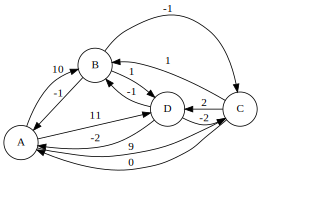

Test passed!!

In [89]:
def test_apsp_dispatchable_form():
    stn = create_example_stn_1()
    dg = convert_stn_to_distance_graph(stn)
    g_apsp = compute_apsp_dispatchable_form(dg)
    
    display_weighted_graph(g_apsp)
    test_apsp_example_stn_1(g_apsp)
    test_ok()

test_apsp_dispatchable_form()

### Offline Scheduler (25 pts) <a id="offline-scheduler"/>

In the above sections, we've focused on converting our STN to a distance graph, then to an APSP dispatchable form. Now, we get to the fun stuff: actually finding a schedule that satisfies all the constraints in the network.

Below, you'll implement a first pass at this - finding a schedule offline. This allows us to assign time values in any (possibly non-monotonically increasing) order.

<br/>
<div class="alert alert-warning">
<strong>Note:</strong> The test function for this part will call schedule_offline hundreds of times. So beware if you use print statements!
</div>
<div class="alert alert-info">
Implement the method below to compute a consistent schedule for a given STN.
</div>

In [12]:
# As always, feel free to define any other functions, classes, etc. that you find useful.

# YOUR CODE HERE
def compute_stn_apsp(g_apsp):
    #pdb.set_trace() 
    stn_apsp = nx.DiGraph()
    edges = list(g_apsp.edges)
    for edge in edges:
        w1 = g_apsp[edge[0]][edge[1]]['weight']
        w2 = -g_apsp[edge[1]][edge[0]]['weight']
        if w1 <= 0:
            continue
        else:
            stn_apsp.add_edge(edge[0], edge[1], stc=[w2, w1])
        
    
    return stn_apsp
        


def schedule_offline(stn, start_event):
    """Computes a fixed schedule offline that satisfies all of the
    temporal constraints in the STN.
    
    Input: stn - a networkx DiGraph with simple temporal constraints
           start_event - a string, the event name in stn of the start event.
                         This start event should always be scheduled at t=0.
                         
    Output: A schedule, which should take the form of a dictionary. The dictionary should
            map event names in the stn to the time at which they are executed. For example,
            {'A': 0.0, ...}
    """
    # YOUR CODE HERE
    dg = convert_stn_to_distance_graph(stn)
    g_apsp = compute_apsp_dispatchable_form(dg)
    stn_apsp = compute_stn_apsp(g_apsp)
    #pdb.set_trace() 
    nodes = list(stn_apsp.nodes)
    node_intervals = {node: [-np.inf,np.inf] for node in nodes} #start with max temporal intervals
    schedule = {node: 0 for node in nodes}
    for node in nodes:
        if node==start_event:
            node_intervals[node]=[0,0]
            
    for i in nodes:
        for j in nodes:
            if i==j:
                continue
            elif stn_apsp.has_edge(i,j):
                LB = node_intervals[i][0] + stn_apsp[i][j]['stc'][0]
                UB = node_intervals[i][1] + stn_apsp[i][j]['stc'][1]
                node_intervals[j]=[LB,UB]
            
        schedule[i] = (node_intervals[i][0] + node_intervals[i][1])/2
    
    return schedule
    

Let's see it in action!

In [13]:
schedule_offline(create_example_stn_1(), 'A')

{'A': 0.0, 'B': 5.5, 'C': 4.5, 'D': 6.5}

Let's test these results:

In [14]:
def test_offline_scheduler():
    check_offline_scheduler(schedule_offline)
    test_ok()

test_offline_scheduler()

Test passed!!

### Scheduling as Linear Programming (10 pts) <a id="scheduling-as-lp"/>

And now for something completely different! In lecture, we presented a number of algorithms for scheduling. We can also frame the problem as a linear program. As a reminder, a linear program takes the form
$$\max_{\mathbf{x}} \mathbf{c}^T \mathbf{x}$$ such that
$$ A \mathbf{x} \leq \mathbf{b}$$

In our formulation, the variables $\mathbf{x}$ represent the scheduled time of events, and the linear constraints in $A$ and $\mathbf{b}$ would take the same form as those from the distance graph. The reward coefficients $\mathbf{c}$ could be chosen however you want.

We're not asking you to implement such an LP system for scheduling, but we would like you to think about it. 

**What advantages and disadvantages do you think using an LP solver with the above formulation would have for a cognitive robot, compared with using the algorithms we discussed in lecture?** Feel free to discuss anything that comes to mind, ranging from practical issues, to theory, to anything else.

<br/>
<div class="alert alert-info">
Enter your thoughts in the following box.
</div>

<center>
LP Formation assuming goal is to minimize time to D (t_D)
<br> 
<br>    
$$
\max_{\mathbf{x}} \mathbf{c}^T \mathbf{x} = \begin{bmatrix} 0 & 0 & 0 & -1 \end{bmatrix} \begin{bmatrix} t_A \\ t_B \\ t_C \\ t_D \end{bmatrix}
$$

<center> such that
<br>  
<br>
    
    
    
$$
A\mathbf{x} \leq \mathbf{b} = 
\begin{bmatrix}
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
0 & -1 & 0 & 1 \\
0 & 0 & -1 & 1 \\
0 & 1 & 0 & -1 \\
0 & 0 & 1 & -1 \\
1 & -1 & 0 & 0 \\
1 & 0 & -1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
t_A \\
t_B \\
t_C \\
t_D \\
\end{bmatrix}
\leq
\begin{bmatrix}
10 \\
10 \\
1 \\
2 \\
2 \\
1 \\
0 \\
0 \\
\end{bmatrix}
$$
<br>

**What advantages and disadvantages do you think using an LP solver with the above formulation would have for a cognitive robot, compared with using the algorithms we discussed in lecture?**
    
**Advantages**:
    1. Unlike STN, the LP solver can handle more than just temporal constraints. Maybe I could have boundary conditions, robot angle and velocity limits that could all be handled by the LP
    2. Modifying the LP for extra constraints that come up will be more versatile and adaptable, but maybe not as intuitive
    3. LPs are well understood and although worst case exponetial usually solve very fast (according to Anoop). So there will be plenty of off the shelf solvers that could be used
    4. LP with Simplex will provide the optimal answer. 
 
**Disadvantages**:
    1. LP constraints for temporal are not as intuitive as STNs and more difficult to write. And the STN dispatchable form provides good intuition on the problem. Good for the robot designer.
    2. APSP I would think is faster for temporal constraint solving than an LP because it is specifically meant for STNs, so LP could be slower which would be worse for a robot planning online and adjusting.
    3. APSP has some flexibility where scheduling intervals can be chosen (min,max,average,etc.) which could be based on non-temporal needs of the robot.

## Part 2 - MILP (100 points)

In [10]:
from math import *
import numpy as np
from Numberjack import *
import csv
from utils import *
from IPython.display import SVG
from nose.tools import assert_equal, ok_

## <a name="part1"></a>Problem 1: LP Formulation (40 points)

In one of the lunar bases that you are building, you are facing a problem of allocating robots for doing the science
experiments autonomously. You would like to come up with a systematic procedure based on linear programming to
solve this allocation problem, which is described more precisely below.


You have $N$ robots to conduct a total of $M$ science experiments autonomously. The percentage of experiment $j$ that
robot $i$ can perform in unit time is given by the constant $T_{i,j}$. You are provided with all the $T_{i,j}$ for all $i = 1,2,...,N$
and $j = 1,2,...,M$. Assume that two or more robots can work on an experiment together to make the experiment faster. In that case, the percentage of the experiment that is completed per unit time will be the sum of the contribution from each robot. 
Formulate **Linear Programs** to answer the following questions (you should formulate one linear program for each bullet point). Clearly define any new variables you introduce.


* Formulate a linear program to minimize the total amount of time that the robots have spent doing the experiments, i.e., the sum (over all robots and all experiments) of the times that each robot has spent for doing all the experiments it has gotten involved in. You could think of it as total robot-hours.


* Assume that you are given a cost $C_{i,j}$ for each robot and experiment pair, i.e., for all $i = 1,2,..., N$ and all $j = 1,2,...,M$. The constant $C_{i,j}$ denotes per unit time cost of robot $i$ performing experiment $j$. For instance, if robot $i$ has worked on experiment $j$ for $t$ time units then the incurred cost is $C_{i,j}t$. Formulate a linear program to minimize the total cost, i.e., the sum of all costs incurred by all robots from all experiments that they are involved in.


* Formulate a linear program that minimizes the total experiment time, i.e., first the time instance that all the robots are finished with all their experiments.

<center>
$$\text{1) Minimize Total Robot-Hours}$$
<br> 
<center>
$$\text{Cost-Function}$$
    <br>
$$
\begin{aligned}
\min_{U} \sum_{j=1}^{M} \sum_{i=1}^{N}U_{ij}
\end{aligned}
$$
$$
\text{where } U_{ij} \text{ is the time units for Robot } i \text{ performing experiment } j
$$
<br>
<center> $$\text{with constraints such that}$$
$$
\forall j = 1,2,...,M: \quad \sum_{i=1}^{N} T_{ij}U_{ij} = 1,  
$$    
<br>
<center> $$\text{and non-zero and integer constraints}$$
$$
\forall i = 1,2,...,N \text{ and } \forall j = 1,2,...,M: \quad  U_{ij} \geq 0 \text{ and } U_{ij} \in \mathbb{R} 
$$
<br>
------------------------------------------------------------------------------------------------------------------------------------------------------------------   
<center>
$$\text{2) Minimize Total Cost}$$
<br> 
<center>
$$\text{Cost-Function}$$
    <br>
$$
\begin{aligned}
\min_{U} \sum_{j=1}^{M} \sum_{i=1}^{N}C_{ij}U_{ij}
\end{aligned}
$$
$$
\text{where } C_{ij} \text{ is the unit time cost of robot i performing experiment j }
$$
<br>
<center> $$\text{with constraints such that}$$
$$
\forall j = 1,2,...,M: \quad \sum_{i=1}^{N} T_{ij}U_{ij} = 1,  
$$    
<br>
<center> $$\text{and non-zero and integer constraints}$$
$$
\forall i = 1,2,...,N \text{ and } \forall j = 1,2,...,M: \quad  U_{ij} \geq 0 \text{ and } U_{ij} \in \mathbb{R} 
$$
<br>
------------------------------------------------------------------------------------------------------------------------------------------------------------------    
<center>
$$\text{3) Minimize Total Experiment Time}$$
<br> 
<center>
$$\text{Cost-Function}$$
    <br>
$$
\min{} T_{final}
$$
<br>
<center> $$\text{with constraints such that}$$
$$
\forall j = 1,2,...,M: \quad \sum_{i=1}^{N} T_{ij}U_{ij} = 1,
$$
$$
\forall i = 1,2,...,N: \quad T_{final}=\max{}\sum_{j=1}^{M}U_{ij}
$$    
<center> $$\text{and non-zero and integer constraints}$$
$$
\forall i = 1,2,...,N \text{ and } \forall j = 1,2,...,M: \quad  U_{ij} \geq 0 \text{ and } U_{ij} \in \mathbb{R},
$$
$$
\forall j = 1,2,...,M: \quad T_{final} \geq 0 \text{ and } T_{final} \in \mathbb{R}
$$
<br>


## <a name="part2"></a>Problem 2: MILP Formulation (20 points)

Clearly describe your variables, constraints, and objective function in your formulations below. You are free to use vectors if you'd like.


### <a name="part2a"></a> Part A: Burglary/Knapsack Problem

Suppose that you are a burgler with a bag of finite capacity $c$. The house which you have broken into has $N$ items of
value $v_i$ and size $s_i$ for $i \in 1...N$. You are trying to steal greatest value from the house, but can only carry what will
fit in your bag. Of course, items themselves are not divisible. Formulate this problem as a MILP.



<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>



<center>
$$\text{1) Burglary/Knapsack Problem}$$
<br> 
<center>
$$\text{Cost-Function}$$
$$
\begin{aligned}
\max\sum_{i=1}^{N}v_{i}x_{i}
\end{aligned}
$$
$$
\text{where } x_{i} \text{ is a binary decision variable}
$$
<br>
<center> $$\text{with constraints such that}$$
$$
\forall i = 1,2,...,N: \quad \sum_{i=1}^{N} s_{i}x_{i} \leq c
$$
<br>
<center> $$\text{and with non-zero and integer constraints}$$
$$
\forall i = 1,2,...,N: \quad  x_{i} \geq 0 \text{ and } x_{i} \leq 1 s_{ij} \text{ and } x_{i} \in \mathbb{Z} 
$$


### <a name="part2b"></a>Part B: Map Coloring


Suppose that you are a map maker and you need to color $N$ countries with $k$ colors. Remember that no two adjacent
countries can be the same color. You can use $k$ distinct colors but each one (paint color) costs a different amount. The
cost is per country colored with that color (regardless of the area of the country). Formulate a MILP that would tell
you how to color the map with minimum cost.

<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>


<center>
$$\text{1) Map Coloring}$$
<br> 
<center>
$$\text{Cost-Function}$$
$$
\begin{aligned}
\min\sum_{i=1}^{N}\sum_{j=1}^{k}C_{j}x_{ij}
\end{aligned}
$$
$$
\text{where } x_{ij} \text{ is a binary decision variable for each country (i) and a specific color (j)}
$$
<br>
<center> $$\text{with constraints such that}$$
    <br>
<center> $$\text{Only one color per country}$$
$$
\forall i = 1,2,...,N: \quad \sum_{j=1}^{k} x_{ij} = 1
$$
<center> $$\text{No adjacent countries have the same color}$$
$$
\forall i = 1,2,...,N \quad \text{and} \quad \forall b = \text{adjacent}(i) \quad \forall \text{colors} \quad k: \quad x_{ik} + x_{bk} \leq 1
$$
<center> $$\text{and with non-zero and integer constraints}$$
$$
\forall i = 1,2,...,N \quad \text{and} \quad \forall j = 1,2,...,k:  x_{ij} \geq 0 \text{ and } x_{ij} \leq 1 \text{ and } x_{ij} \in \mathbb{Z} 
$$

## <a name="part3"></a>Problem 3: MILP encoding using Numberjack 

In these two subproblems we'll use Numberjack to solve Mixed-Integer Linear Programs.

The following example shows how to do that. You can refer to [Numberjack's documentation](http://numberjack.ucc.ie/doc/) for more information. In particular, the `Sum` function may be useful in this problem set. Also, remember to use the `SCIP` solver, as that's the one that supports MILPs.

In [11]:
# MILP example using Numberjack
x = Variable() # Binary 0-1 variable
y = Variable(0.0, 10.0) # Continuous variable between 0 and 10

obj = 5 * x + y # Expression with variables (for the objective function)
limit = 10 * x + 10 * y # Expression with variables for the constraint
model = Model(
        Maximize(obj), # maximize this objective
        limit <= 48.5 # constraint (can add more constraints with commas)
        )
solver = model.load('SCIP') # The SCIP solver is the only one that supports MILPs
solver.solve()
if solver.is_opt(): # Optimal solution returned
    print("x: %f, y:%f, Objective: %f, Constraint: %f" %(x.get_value(), y.get_value(), obj.get_value(),
                                                        limit.get_value()))

x: 1.000000, y:3.850000, Objective: 8.850000, Constraint: 48.500000


## <a name="part3a"></a>Problem 3-A: A MILP approach to the Knapsack (10 points)

The [Knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem) is a classic combinatorial optimization problem. We would like to show a way of solving the [Knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem) that doesn't involve generating all possible choices naïvely using a bruteforce approach (that will only work for small instances). This problem can be modeled as an mixed integer linear problem, for example.


Remember the problem: a thief breaks into a house with a knapsack of a given size and tries to steal as much as he can. He can't put everything into the knapsack, due to space constraints. The knapsack problem consists on chosing the items to put in the knapsack so that the combined value of all the collected items is maximized, and the size constraint of the knapsack is satisfied.

The list of items with their sizes and values is given next:

In [18]:
# Data from the items table in Python dictionaries
# changes that you make to this cell will be overwritten by our autograding software.
sizes_dict = dict(ring=1, candelabra=5, radio=3, elvis=4, laptop=4, xbox=6, guitar=7, album=3, shoes=3)
values_dict = dict(ring=15, candelabra=10, radio=9, elvis=5, laptop=12, xbox=10, guitar=9, album=1, shoes=2)

Implement the function `best_knapsack_milp(sizes_dict, values_dict, knapsack_size)` to solve the Knapsack Problem using a MILP formulation and Numberjack. Your function should take the dictionaries of the item sizes and values (as given above) and the size of the knapsack (a float value greater than 0).

The output of your function should be a tuple `(chosen_items, cummulative_value, cummulative_size)` such that:

- `chosen_items` is a list of the items chosen by the thief
- `cummulative_value` is the total value of the items chosen
- `cummulative_size` is the total size of the items chosen

The chosen items should maximize the total value for the given size of the knapsack.

A sample return value for `best_knapsack_milp(sizes_dict, values_dict, 13)` would be: `(['guitar', 'xbox'], 19.0, 13.0)`. (Although this wouldn't be an optimal solution -- your function needs to return an optimal one).

<div class="alert alert-info">
Implement the function `best_knapsack_milp(sizes_dict, values_dict, knapsack_size)` below.
</div>

In [84]:
def best_knapsack_milp(sizes_dict, values_dict, knapsack_size):
    # YOUR CODE HERE
    X=[]
    for i in range(len(sizes_dict)):
        X.append(Variable(0,1)) # handles binary, integer constraint here
        
    values_list = list(values_dict.values())
    sizes_list = list(sizes_dict.values())
    
    #Cost Function
    obj = Sum(X[i] * values_list[i] for i in range(len(X)))
    
    # Sack Capacity
    sack_limit = Sum(X[i] * sizes_list[i] for i in range(len(X)))
        
    
    model = Model(
            Maximize(obj), # maximize this objective
            sack_limit <= knapsack_size, 
            )  # constraint (can add more constraints with commas)
    solver = model.load('SCIP') # The SCIP solver is the only one that supports MILPs
    
    solver.solve()

    #chosen_items = [key for key, value in values_dict.items() if x[i].get_value() == 1 for i in range(i)]
    item_list = list(values_dict.keys())
    chosen_items = []
    for i in range(len(X)):
       #print(i)
        if X[i].get_value() == 1:
            #print(X[i])
            chosen_items.append(item_list[i])

    #print('chosen items',X)
    cumulative_value = obj.get_value()
    cumulative_size = sack_limit.get_value()
    return (chosen_items, cumulative_value, cumulative_size)


In [83]:
"""Test `best_knapsack_milp(sizes_dict, values_dict, knapsack_size)`"""
# THE TEST IS A VERY LIMITED CHECK. PASSING THE TEST DOESN'T IMPLY THAT FULL CREDIT WILL BE GIVEN.
# YOUR CODE WILL BE CHECKED BY HAND
# This cell will be overwritten by our autograder code.
test_knap = 16
test_chosen, test_value, test_size = best_knapsack_milp(sizes_dict, values_dict, 16)
print("The best choices for a knapsack of size %d are: %s with value=%d and size =%d"%(test_knap,
                                                                                    test_chosen,
                                                                                    test_value, test_size))
assert_equal(set(test_chosen), set(['laptop', 'candelabra', 'radio', 'ring', 'shoes']))
assert_equal(test_value, 48.0);assert_equal(test_size, test_knap)
test_ok()

The best choices for a knapsack of size 16 are: ['ring', 'candelabra', 'radio', 'laptop', 'shoes'] with value=48 and size =16


Test passed!!

## <a name="part3b"></a>Problem 3-B: Map Coloring using a MILP (30 points)

In this problem we'll be solving the map coloring problem using a MILP formulation. We'll be coloring the states of the United States.

Remember that in the map coloring problem, no neighbors (adjacent states in this case) can share the same color.

We provide the list of adjacent states to a given state below.

In [5]:
adjacent_states = load_adjacent_states()
print("Adjacent states (%d, counting DC):" %(len(adjacent_states)))
for st in sorted(adjacent_states.keys()):
    print("{} : {}".format(st, adjacent_states[st]))

Adjacent states (51, counting DC):
AK : []
AL : ['MS', 'TN', 'GA', 'FL']
AR : ['MO', 'TN', 'MS', 'LA', 'TX', 'OK']
AZ : ['CA', 'NV', 'UT', 'CO', 'NM']
CA : ['OR', 'NV', 'AZ']
CO : ['WY', 'NE', 'KS', 'OK', 'NM', 'AZ', 'UT']
CT : ['NY', 'MA', 'RI']
DC : ['MD', 'VA']
DE : ['MD', 'PA', 'NJ']
FL : ['AL', 'GA']
GA : ['FL', 'AL', 'TN', 'NC', 'SC']
HI : []
IA : ['MN', 'WI', 'IL', 'MO', 'NE', 'SD']
ID : ['MT', 'WY', 'UT', 'NV', 'OR', 'WA']
IL : ['IN', 'KY', 'MO', 'IA', 'WI']
IN : ['MI', 'OH', 'KY', 'IL']
KS : ['NE', 'MO', 'OK', 'CO']
KY : ['IN', 'OH', 'WV', 'VA', 'TN', 'MO', 'IL']
LA : ['TX', 'AR', 'MS']
MA : ['RI', 'CT', 'NY', 'NH', 'VT']
MD : ['VA', 'WV', 'PA', 'DC', 'DE']
ME : ['NH']
MI : ['WI', 'IN', 'OH']
MN : ['WI', 'IA', 'SD', 'ND']
MO : ['IA', 'IL', 'KY', 'TN', 'AR', 'OK', 'KS', 'NE']
MS : ['LA', 'AR', 'TN', 'AL']
MT : ['ND', 'SD', 'WY', 'ID']
NC : ['VA', 'TN', 'GA', 'SC']
ND : ['MN', 'SD', 'MT']
NE : ['SD', 'IA', 'MO', 'KS', 'CO', 'WY']
NH : ['VT', 'ME', 'MA']
NJ : ['DE', 'PA', 'NY']
N

Implement the function `assign_state_colors(valid_colors, adjacent_states)` that takes a list of colors and the dictionary with the list of adjacent states to a given state and produces a tuple: `(state_colors, color_counts)` where:

- `state_colors` is a dictionary assigning one of the colors from `valid_colors` to each state.
- `color_counts` is a list of integers corresponding to the number of states that have been assigned a given color for each color. The size of `color_counts` is therefore the same as `valid_colors`. The counts need to be in the same order as `valid_colors`.

Additionally, find an assignment that **maximizes** the following objective: "the number of states assigned the second color (index 1) minus two times the number of states assigned the first color (index 0)". This corresponds to `color_counts[1] - 2*color_counts[0]`.

This can be expressed as a MILP (note that you may need more than one variable per state).
Use Numberjack with the `SCIP` solver to formulate and solve this MILP.

Your function should return `(None, None)` if no possible assignment exists with the given list of colors.

As an example, the following code produces a random color assignment without taking into account the constraints or the optimization objective

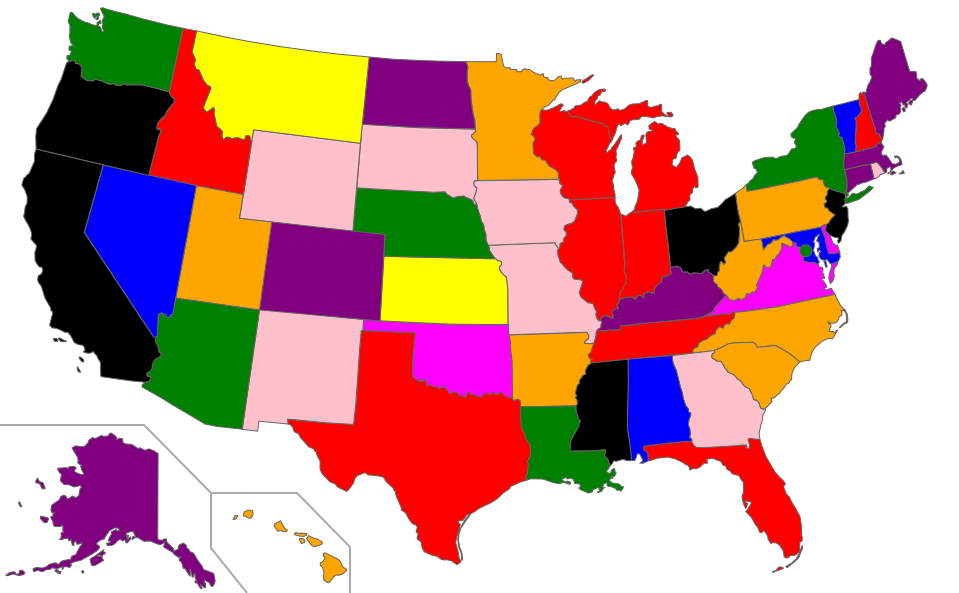

In [9]:
valid_colors = ['red','blue','pink','yellow', 'magenta', 'purple', 'orange', 'green', 'black']
def random_state_colors(valid_colors, adjacent_states):
    solution = dict([(st, np.random.choice(valid_colors)) for st in adjacent_states.keys()])
    return solution
random_state_colors = random_state_colors(valid_colors, adjacent_states)
plot_map(random_state_colors)

Make sure that your function can accept any number $k$ of colors.

What's the minimum number of colors that you need?

<div class="alert alert-info">
Implement the function `assign_state_colors(valid_colors, adjacent_states)` below.
</div>

In [177]:
def assign_state_colors(valid_colors, adjacent_states):
# YOUR CODE HERE
    states = list(adjacent_states.keys())
    adjacents = list(adjacent_states.values())
    #print(len(states))
    #print(len(valid_colors))
    # Decision Variables (204 in a list in alphabetical state order and each color, ex. first is AK (red))
    X=[]
    for i in range(len(states)):
        for k in range(len(valid_colors)):
            X.append(Variable(0,1)) # decision variable, handles binary, integer constraint here          
    #print(len(X))
    #Objective Function
    sum_first_color = 0
    sum_second_color = 0
    
    for i in range(len(X)):
        if i % len(valid_colors) == 0:  # Checks if remainder is zero, corresponds to the first color for each state
            sum_first_color += X[i]
        elif i % len(valid_colors) == 1:  # Checks if remainder is one, corresponds to the second color for each state
            sum_second_color += X[i]
            
    obj = sum_second_color - 2*sum_first_color # apply the formula
    
    #Cost Function (no more than 1 color per country ~ 51 constraints)
    limit_1 = []
    constraint_array = []
    index_counter = 0
    for i in range(len(X)//len(valid_colors)):
        for k in range(len(valid_colors)):
            constraint_array.append(X[index_counter+k])
        constraint = Sum(constraint_array)
        index_counter = index_counter + len(valid_colors)
        constraint_array = []
        #print(constraint)
        limit_1.append(constraint)
    #print(len(limit_1))
    
    #Cost Function (no same colors in adjacent states)
    limit_2 = []
    for state, adjacent in zip(states, adjacents):
        state_index = states.index(state)
        #print(state_index)
        if not adjacent:
            continue
        #if state_index >=3:
            #continue
        
        for b in adjacent:
            adj_index = states.index(b)
            if state_index < adj_index:
                state_counter = len(valid_colors) * state_index
                adj_counter = len(valid_colors) * adj_index
                for k in range(len(valid_colors)):
                    constraint = X[state_counter] + X[adj_counter]
                    #print(constraint)
                    #limit_2.append(constraint)
                    #if constraint not in limit_2:
                    limit_2.append(constraint)
                    #limit_2.append(X[state_counter] + X[adj_counter])
                    #print(state_counter)
                    #print(adj_counter)
                    state_counter += 1
                    adj_counter += 1
                    
    model = Model(Maximize(obj))
    
    for constraint_1 in limit_1:
        model += constraint_1 == 1
    
    #limit_2 = X[4] + X[100]
    #model += limit_2 <= 1
    
    for constraint_2 in limit_2:
        model += constraint_2 <= 1
    
    solver = model.load('SCIP') # The SCIP solver is the only one that supports MILPs
    solver.solve()
    if solver.is_opt():
        print('solution')
    
    state_colors = {}
    color_counts = [0] * len(valid_colors)
    state_counter = 0
    for i in range(len(X)):
        #print(X[i].get_value())
        if i % len(valid_colors) == 0:
            color_counter = 0
            
        if X[i].get_value() == 1:
            #print('state',state_counter)
            #print('color',color_counter)
            state_colors[states[state_counter]] = valid_colors[color_counter]
            color_counts[color_counter] += 1
            #print(color_counts)
        
        if (i + 1) % len(valid_colors) == 0:
            state_counter += 1
        color_counter += 1
            
    print('state_colors',state_colors)
    print('color_counts',color_counts)
    return (state_colors, color_counts)

    

solution
state_colors {'AK': 'blue', 'AL': 'pink', 'AR': 'pink', 'AZ': 'red', 'CA': 'yellow', 'CO': 'yellow', 'CT': 'yellow', 'DC': 'blue', 'DE': 'blue', 'FL': 'blue', 'GA': 'yellow', 'HI': 'blue', 'IA': 'pink', 'ID': 'yellow', 'IL': 'blue', 'IN': 'yellow', 'KS': 'pink', 'KY': 'pink', 'LA': 'blue', 'MA': 'pink', 'MD': 'pink', 'ME': 'yellow', 'MI': 'blue', 'MN': 'blue', 'MO': 'yellow', 'MS': 'yellow', 'MT': 'blue', 'NC': 'pink', 'ND': 'pink', 'NE': 'blue', 'NH': 'blue', 'NJ': 'pink', 'NM': 'pink', 'NV': 'pink', 'NY': 'blue', 'OH': 'red', 'OK': 'blue', 'OR': 'blue', 'PA': 'yellow', 'RI': 'blue', 'SC': 'blue', 'SD': 'yellow', 'TN': 'blue', 'TX': 'yellow', 'UT': 'blue', 'VA': 'yellow', 'VT': 'yellow', 'WA': 'pink', 'WI': 'yellow', 'WV': 'blue', 'WY': 'pink'}
color_counts [2, 20, 14, 15]


Test passed!!

Color counts:
red: 2
blue: 20
pink: 14
yellow: 15


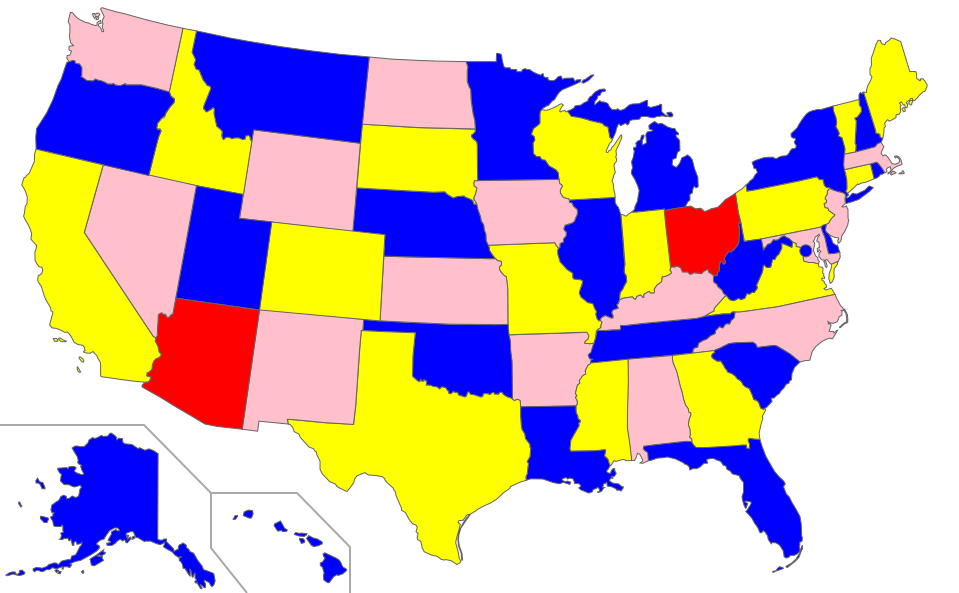

In [178]:
"""Test assign_colors"""
# THE TEST IS A VERY LIMITED CHECK. PASSING THE TEST DOESN'T IMPLY THAT FULL CREDIT WILL BE GIVEN.
# YOUR CODE WILL BE CHECKED BY HAND
# This cell will be overwritten by our autograder code.
valid_colors = ['red','blue','pink','yellow']
test_color_assignment, test_color_counts = assign_state_colors(valid_colors, adjacent_states)
check_color_assignments(valid_colors, test_color_assignment, test_color_counts)
assert_equal(test_color_counts[1] - 2*test_color_counts[0], 16)
test_ok()
print("Color counts:")
for col, count in zip(valid_colors, test_color_counts):
    print("%s: %d"%(col, count))
plot_map(test_color_assignment)